# FYP Assignment 3 - Data Preprocessing

Exploratory data analysis, visualization, and preprocessing of Zheng's energy consumption dataset.

# Exploratory Data Analysis

## Reading Data

In [9]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Imports for formatting dates
import matplotlib.dates as mdates

In [2]:
# Reading the entire dataset into a pandas dataframe - tractable because 167 MB
data = pd.read_csv('./data.csv')

## Data Overview

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1036 entries, CONS_NO to 2016/9/9
dtypes: float64(1034), int64(1), object(1)
memory usage: 334.9+ MB


### Interpretation
- **42,372 rows** in the dataset, which means there are 42,372 training examples.
- **1,036 columns** in the dataset(!)
    - 1 is `CONS_NO`: the unique identifier for consumers in the dataset. This is most likely an `object`.
    - Another column is an `int64` - most likely the `FLAG`.
    - Remaining **1,034 columns are all kWhs, and are `float64`s**, so won't have to be cast later on.
- ~340M MB of memory used. Even on my PM laptop, this isn't too much.
    - This means I can play around with the data on a mid-tier laptop without waiting too much.

## Statistical Summary - Numerical Columns

Will examine the `mean`, `std`, `min`, `max`, and `count` for all columns except `CONS_NO`. This will also give me a good first look at the dataset.

In [4]:
# Save the description into a new dataframe to index counts for visualizing missing values
description_df = data.describe()

In [5]:
# Echo the dataframe
description_df

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
count,42372.000000,25870.000000,25912.000000,25911.000000,25912.00000,25912.000000,25912.000000,25915.000000,25924.000000,25925.000000,...,40544.000000,41482.000000,41915.000000,41151.000000,41906.000000,41873.000000,41850.000000,41967.000000,42044.000000,42027.00000
mean,0.085316,7.168735,6.954202,6.784099,7.08430,10.516470,7.219633,7.341512,7.160004,6.839875,...,8.836129,9.304656,10.758718,9.942215,11.173498,11.482926,11.656425,11.322680,11.015589,10.69165
std,0.279354,34.131237,40.017856,38.327058,31.98716,576.388348,34.703617,36.569049,36.916957,30.235396,...,52.371956,57.063621,88.039832,62.010381,94.267851,100.971180,118.369381,103.891111,100.614909,107.25814
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.820000,0.880000,0.880000,0.900000,0.920000,0.940000,0.910000,0.910000,0.90000
50%,0.000000,3.310000,2.870000,2.900000,3.35000,3.440000,3.295000,3.470000,3.130000,3.250000,...,4.380000,4.670000,5.010000,4.820000,5.150000,5.110000,5.190000,5.110000,5.020000,4.93000
75%,0.000000,8.910000,8.170000,8.210000,8.76000,8.620000,8.740000,8.900000,8.780000,8.520000,...,9.300000,9.380000,10.740000,9.700000,11.380000,11.430000,11.600000,11.300000,10.730000,10.28000
max,1.000000,3318.000000,3966.000000,4392.000000,3414.00000,92713.900000,3167.000000,3960.000000,3654.000000,3306.000000,...,6324.000000,6990.000000,14640.000000,6672.000000,16320.000000,17100.000000,21210.000000,17940.000000,16710.000000,18570.00000


### Interpretation
- There are far too many columns in the dataset to identify missing, null, or erroneous values by inspection.
- There is a problem with the dates - they are not in the right order. 10th January, 2014 follows 1st January, 2014. Is this because the columns are being treated as strings?
- There are indeed 42,372 consumers, as shown in the `count` for the `FLAG`
- Missing values aplenty in the first few columns. 
- `FLAG` is the target variable: what we will be trying to predict.
    - Max and min values for the `FLAG` column are 0 and 1, which confirms that there is no erroneous value (negative flag, or third category of flag) in the target column.
    - All other columns (dates) are features: what we will be using to make classifications.
    - `mean` of `FLAG` is very close to 0, which suggests this is a right skewed binary distribution in which more consumers have `FLAG` of `0` as opposed to `1`.
    - **TODO**: Ask Dr. AB how to intepret standard deviation of `FLAG`.
    - No missing values in the `FLAG` column since `count` is same as number of rows in dataset. 

## Checking for Negative kWhs
Negative value for kWhs is erroneous data. Need to identify if such a value exists. Can't do this by inspection of `head`. Have to do it programmatically.

In [6]:
# Extract kWh values into a numpy array to check for negative values
kWh_vals = data.iloc[:, 2:].values

# Check that the numpy array has one row per consumer, one column per date
assert kWh_vals.shape == (len(data), len(data.columns[2:]))

In [7]:
# Is there any negative value in the kWhs?
np.any(data.iloc[:, 2:] < 0) == True

False

### Interpretation
This confirms that while there may be `NaN`s in the kWhs, there are no negative kWhs i.e. erroneous values. This is one less thing to worry about when preprocessing the data later.

## Visualizing Missing Values
We've established that there are no **negative** kWh readings in the dataset, which means there are only two types of values left for the kWh: positive `float64` or `NaN` aka missing values.

Since there are more than 1,000 columns in the dataset, using `head` to visualize missing values in each column (actually on each day) is intractable. 

Instead, creating a new dataframe of non-null values in each column of the dataset and plotting it to show the trend in the number of missing values in the dataset.

**This plot will not show a chronological trend** because the columns have not been sorted yet.

In [8]:
# Extract counts for all dates - this will then be plotted to visualize missing values
value_counts = description_df.loc['count'].drop('FLAG')

In [9]:
"""Create an array of ones scaled by the max number of value counts - this is the maximum
number of kWh values we could have at any given date. Making a list helps me plot this 
as a straight line on a graph as a threshold"""
max_threshold = np.ones(len(value_counts)) * np.max(value_counts)

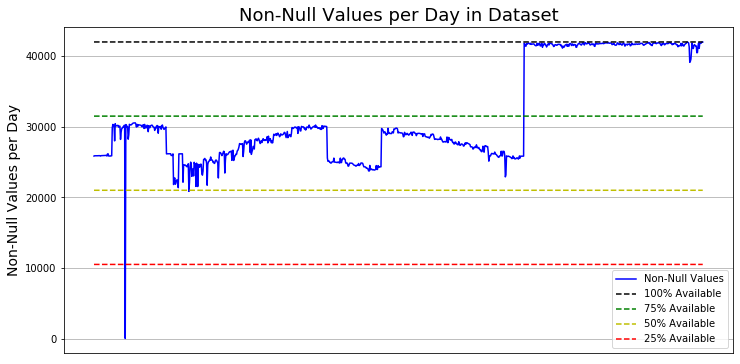

In [10]:
# Create plot of non-null values
plt.figure(figsize=(12, 6))
plt.plot(value_counts, 'b-', label='Non-Null Values')
plt.plot(max_threshold, 'k--', label='100% Available')
plt.plot(0.75 * max_threshold, 'g--', label='75% Available')
plt.plot(0.50 * max_threshold, 'y--', label='50% Available')
plt.plot(0.25 * max_threshold, 'r--', label='25% Available')
plt.xticks([]) # Do not want indices or dates for now
plt.ylabel('Non-Null Values per Day', fontsize=14)
plt.title('Non-Null Values per Day in Dataset', fontsize=18)
plt.grid(); plt.legend()

### Interpretation
There is clearly **one day when the number of non-null values drop to ~0**. This day should be dropped from the data unless we can figure out how to fill in these missing values using data from previous and next days/weeks.

On most days, the number of non-null values is between 50% and 75% of the total number of consumers in the dataset. Near complete set of readings is only available towards the end of the dataset i.e in 2016.

There is also **no day where all 42,372 consumers reported a non-null reading**.

In [11]:
# Minimum number of non-null kW readings recorded on a day
min_readings = np.min(value_counts)
max_readings = np.max(value_counts) 
print(f"Min Readings: {min_readings}\nMax Readings: {max_readings}")

# What is the index of the column where minimum non-null value count occurs?
idx_min = value_counts.idxmin()

Min Readings: 15.0
Max Readings: 42044.0


In [12]:
# What is the date of the day with the 
idx_min

'2014/10/3'

In [13]:
# Display statistics for this day
data[[idx_min]].describe()

,2014/10/3
count,15.000000
mean,484.908667
std,772.293554
min,15.300000
25%,50.300000
50%,144.000000
75%,334.500000
max,2463.000000


### Interpretation
The number of non-null values in the dataset dropped to 15 on 3rd October, 2014. 

**TODO**: Ask Dr. AB whether we should drop this column from the sequence entirely. 

## Class Distribution

In [14]:
# Count non-null values in each column based on FLAG column value
grouped_by_flag = data.groupby('FLAG').count()
grouped_by_flag

,CONS_NO,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
FLAG,,,,,,,,,,,,,,,,,,,,,
0,38757,23742,23773,23773,23773,23772,23774,23778,23781,23782,...,37121,38025,38413,37674,38403,38374,38341,38459,38544,38526
1,3615,2128,2139,2138,2139,2140,2138,2137,2143,2143,...,3423,3457,3502,3477,3503,3499,3509,3508,3500,3501


In [15]:
# Extract the number of consumers
grouped_by_flag[['CONS_NO']]

,CONS_NO
FLAG,
0,38757
1,3615


In [16]:
# What does this mean in terms of percentage of total consumers?
print("%age distribution of classes\nb")
print(grouped_by_flag[['CONS_NO']]/len(data[['CONS_NO']]))

%age distribution of classes
b
       CONS_NO
FLAG          
0     0.914684
1     0.085316


Text(0.5, 1.0, 'Class Distribution')

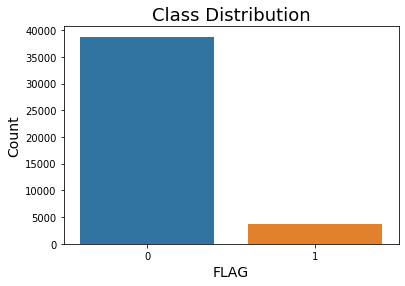

In [17]:
# Countplot will distribute values according to class
sns.countplot(x='FLAG', data=data)
plt.xlabel('FLAG', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Class Distribution', fontsize=18)

### Interpretation
This is an **unbalanced classification problem** - there is a **91.5-8.5% split** between negative and positive (target) class in the dataset. This corroborates earlier finding of right skewed distribution and low mean.

## Visualizing Missing Values per Category
Do regular consumers have more or fewer missing values than thieves? Are thieves bypassing their electricity meters more than regular consumers?

In [18]:
# Echoing because I'm lazy
grouped_by_flag.head()

,CONS_NO,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
FLAG,,,,,,,,,,,,,,,,,,,,,
0,38757,23742,23773,23773,23773,23772,23774,23778,23781,23782,...,37121,38025,38413,37674,38403,38374,38341,38459,38544,38526
1,3615,2128,2139,2138,2139,2140,2138,2137,2143,2143,...,3423,3457,3502,3477,3503,3499,3509,3508,3500,3501


In [19]:
# Get regular consumer's non-null values. 1st column onwards selects counts on each day
reg_non_null_counts = grouped_by_flag.iloc[0, 1:] 
thieves_non_null_counts = grouped_by_flag.iloc[1, 1:]

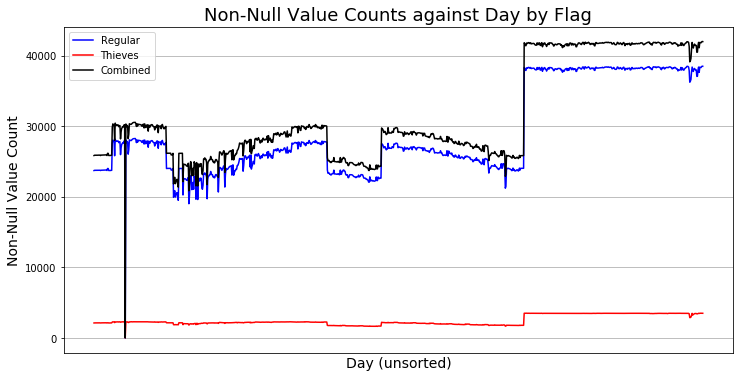

In [20]:
# Plot the number of non-null values per day for each class along with total number of non-null values per day
plt.figure(figsize=(12, 6))
plt.plot(reg_non_null_counts, 'b-', label='Regular')
plt.plot(thieves_non_null_counts, 'r-', label='Thieves');
plt.plot(value_counts, 'k-', label='Combined')
plt.title('Non-Null Value Counts against Day by Flag', fontsize=18)
plt.xticks([]); plt.xlabel('Day (unsorted)', fontsize=14);
plt.ylabel('Non-Null Value Count', fontsize=14); plt.grid(True); plt.legend()

### Interpretation
This plot shows that there is a lot more variation in the number of missing values for regular consumers than in those of thieves. The number of non-null values in thieves is more or less a flat line with an occasional jump here and there.

However, this may just be because the proportion of thief values in the dataset is very small, so on the scale of this graph, it gives the false impression that there isn't much variation. There could be a substantial number of missing thief values as a percentage of the total thief values. Needs further investigation.

This would also explain why the overall trend follows the pattern of the number of non-null regular consumers per day so closely. The number of regular consumers' non-null values is dominating the overall number of missing values. 

In [21]:
# Total number of consumers - found using number of unique consumer numbers
total_consumers = data[['CONS_NO']].nunique()
print("Total Consumers: ", total_consumers)

# Total number of regular consumers and thieves - found by grouping by flag
total_reg_consumers = grouped_by_flag[['CONS_NO']].loc[0]
total_thieves = grouped_by_flag[['CONS_NO']].loc[1]

print("Regular Consumers: ", total_reg_consumers)
print("Thieves: ", total_thieves)

Total Consumers:  CONS_NO    42372
dtype: int64
Regular Consumers:  CONS_NO    38757
Name: 0, dtype: int64
Thieves:  CONS_NO    3615
Name: 1, dtype: int64


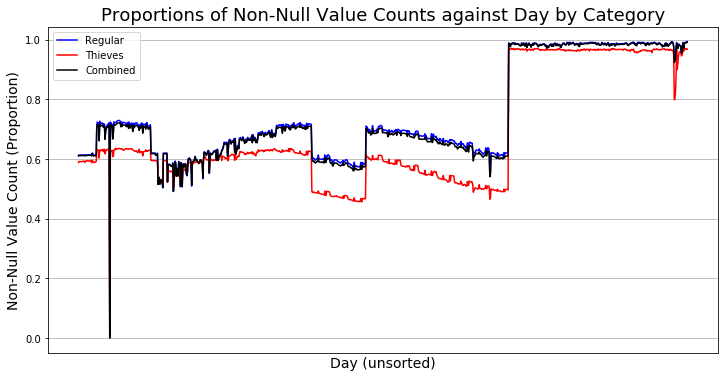

In [22]:
# Will use these constants to plot non-null values as proportion of their respective category
plt.figure(figsize=(12, 6))
plt.plot(reg_non_null_counts / float(total_reg_consumers), 'b-', label='Regular')
plt.plot(thieves_non_null_counts / float(total_thieves), 'r-', label='Thieves');
plt.plot(value_counts / float(total_consumers), 'k-', label='Combined')
plt.title('Proportions of Non-Null Value Counts against Day by Category', fontsize=18)
plt.xticks([]); plt.xlabel('Day (unsorted)', fontsize=14);
plt.ylabel('Non-Null Value Count (Proportion)', fontsize=14); plt.grid(True); plt.legend()

### Interpretation

This graph gives a much better indication of the number of missing values per day for the entire dataset (shown in the black line) as well as for individual categories (thieves and regular consumers shown in red and blue respectively).

It confirms my suspicion that the apparent lack of variation in number of non-null thief values was only due to the scale of the raw thief counts being orders of magnitude smaller than those of regular consumers and the entire dataset. Once the number of non-null kWh readings for thieves per day are scaled by the maximum number of values that could have been measured, the trend is very similar to the entire dataset and to the regular consumers.

**Ideas to Consider**
- **Missing Values As Features**: There is a significant difference (~-0.1 units) between the proportion of non-null values for thieves and regular consumers. Could this mean that the absence of kWh readings can be a possible feature for distinguishing the two?
- **Why**: why is there a difference between the proportion of non-null values for thieves and regular consumers? Could this be due to thieves bypassing their meters? Is this relevant?

## Rearranging Columns Chronologically (Test)

The most glaring issue in the dataset right now, other than the large number of `NaN`s is the fact that the dataset's columns are not sorted chronologically. This isn't a problem with `pandas` or the way it reads values from a CSV: the same sequence of columns is present in the original CSV when examined with Excel.

In [23]:
# What is the data type of the columns?
cols = data.columns.tolist()

# Output the values starting from the 2nd index 
print(cols[2:10])

# What is the type of each of these dates? Is it a string or a datetime?
print(type(cols[2]))

['2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13', '2014/1/14', '2014/1/15', '2014/1/16']
<class 'str'>


### Interpretation
The dates are stored as **strings** and not as `datetime` objects, which would explain why they appear to be out of order: they are sorted lexicographically rather than chronologically.

The solution is to convert each column header from `string` to `datetime`, and then sort the dataset according to `datetime` values in ascending order. This will get rid of the lack of sequence.

In [29]:
# Making a copy of the dataset to test modification of columns
new_df = data.iloc[:,:]

In [30]:
# Should be the same as the original dataset
new_df.describe()

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
count,42372.000000,25870.000000,25912.000000,25911.000000,25912.00000,25912.000000,25912.000000,25915.000000,25924.000000,25925.000000,...,40544.000000,41482.000000,41915.000000,41151.000000,41906.000000,41873.000000,41850.000000,41967.000000,42044.000000,42027.00000
mean,0.085316,7.168735,6.954202,6.784099,7.08430,10.516470,7.219633,7.341512,7.160004,6.839875,...,8.836129,9.304656,10.758718,9.942215,11.173498,11.482926,11.656425,11.322680,11.015589,10.69165
std,0.279354,34.131237,40.017856,38.327058,31.98716,576.388348,34.703617,36.569049,36.916957,30.235396,...,52.371956,57.063621,88.039832,62.010381,94.267851,100.971180,118.369381,103.891111,100.614909,107.25814
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.820000,0.880000,0.880000,0.900000,0.920000,0.940000,0.910000,0.910000,0.90000
50%,0.000000,3.310000,2.870000,2.900000,3.35000,3.440000,3.295000,3.470000,3.130000,3.250000,...,4.380000,4.670000,5.010000,4.820000,5.150000,5.110000,5.190000,5.110000,5.020000,4.93000
75%,0.000000,8.910000,8.170000,8.210000,8.76000,8.620000,8.740000,8.900000,8.780000,8.520000,...,9.300000,9.380000,10.740000,9.700000,11.380000,11.430000,11.600000,11.300000,10.730000,10.28000
max,1.000000,3318.000000,3966.000000,4392.000000,3414.00000,92713.900000,3167.000000,3960.000000,3654.000000,3306.000000,...,6324.000000,6990.000000,14640.000000,6672.000000,16320.000000,17100.000000,21210.000000,17940.000000,16710.000000,18570.00000


In [31]:
# Extract the date columns only - not `FLAG` or `CONS_NO`
columns = new_df.columns[2:]

In [32]:
# Convert to datetime in specified format
new_cols = pd.to_datetime(columns)

In [33]:
# Attempt to sort after casting to datetime
new_cols.sort_values()

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2016-10-22', '2016-10-23', '2016-10-24', '2016-10-25',
               '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29',
               '2016-10-30', '2016-10-31'],
              dtype='datetime64[ns]', length=1034, freq=None)

In [34]:
# Checking indices of original columns list to identify where dates begin
print(new_df.columns[:2])
print(new_df.columns[2:])

Index(['CONS_NO', 'FLAG'], dtype='object')
Index(['2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13',
       '2014/1/14', '2014/1/15', '2014/1/16', '2014/1/17', '2014/1/18',
       ...
       '2016/9/28', '2016/9/29', '2016/9/3', '2016/9/30', '2016/9/4',
       '2016/9/5', '2016/9/6', '2016/9/7', '2016/9/8', '2016/9/9'],
      dtype='object', length=1034)


Extract first two columns (`CONS_NO` and `FLAG`) because they don't need to be cast to `datetime`. Then extract the actual date strings (column indices 2 onwards) and cast them to `datetime` and extract **only** the date using the `date` attribute - without it, all column names have an unnecessary `00:00:00` at the end. 

Must concatenate both sets of columns as lists and then assign the result to the new dataframe's columns.

In [35]:
# Concatenate original `CONS_NO` and `FLAG` with **UNSORTED** datetime column names
new_df.columns = new_df.columns[:2].tolist() + pd.to_datetime(new_df.columns[2:]).date.tolist()

In [36]:
# Did it work?
new_df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,...,2016-09-28,2016-09-29,2016-09-03,2016-09-30,2016-09-04,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31


It worked. Now to sort the columns in ascending order.

In [37]:
# Extract list of column names
dt_cols = new_df.columns[2:]

# Sort them in ascending order
sorted_dt_cols = dt_cols.sort_values()

# Did it work?
print(sorted_dt_cols[:25]) 

Index([2014-01-01, 2014-01-02, 2014-01-03, 2014-01-04, 2014-01-05, 2014-01-06,
       2014-01-07, 2014-01-08, 2014-01-09, 2014-01-10, 2014-01-11, 2014-01-12,
       2014-01-13, 2014-01-14, 2014-01-15, 2014-01-16, 2014-01-17, 2014-01-18,
       2014-01-19, 2014-01-20, 2014-01-21, 2014-01-22, 2014-01-23, 2014-01-24,
       2014-01-25],
      dtype='object')


In [38]:
# Extract the kW into a separate df
kw_df = new_df.iloc[:, 2:]

In [39]:
kw_df.head()

,2014-01-01,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,...,2016-09-28,2016-09-29,2016-09-03,2016-09-30,2016-09-04,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31


In [40]:
# Extract the consumer number and flags
cons_flags_df = new_df.iloc[:, :2]

# Extract the kWhs separately
kWhs_df = new_df.iloc[:, 2:]

# Sort the kWhs dataframe according to their columns
kWhs_df.sort_index(axis=1, inplace=True, ascending=True)

# Did it work?
kWhs_df.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [41]:
# For merging the two dataframes together by INNER JOIN, use CONS_NO as key
kWhs_df.insert(0, 'CONS_NO', new_df[['CONS_NO']])

In [42]:
kWhs_df.head()

,CONS_NO,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [43]:
# Join the dataframes using CONS_NO as key
sorted_df = pd.merge(left=cons_flags_df, right=kWhs_df, how='left', 
                    on='CONS_NO', left_index=True, right_index=False)

In [44]:
# Did it work?
sorted_df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [45]:
# Compare to original data
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,...,2016-09-28,2016-09-29,2016-09-03,2016-09-30,2016-09-04,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31


In [47]:
# Save to a new CSV file that can be loaded in future sessions
# `index` = False means data won't have an additional col of [0, 1, 2, ..., 42371]
sorted_df.to_csv('./sorted_data.csv', index=False)

### Recap of Sorting Workflow
1. Separate into 2 dataframes - the first being `CONS_NO` and `FLAG`, and the second being `kWhs` 
    - Including `CONS_NO` in both because it helps me join them using `CONS_NO` as a key.
    - Do not include the `CONS_NO` with the `kWhs` at first. Will be done later.
2. Extract column names from the kWhs dataframe and cast them to `datetime` objects.
    - Drop the time, only the date is necessary.
    - Reassign the column names. Don't save them into a separate variable.
3. Use the `sort_index` method on the `kWh` dataframe to reorganize columns in chronological order.
4. Insert the `CONS_NO` column in the sorted/rearranged `kWh` dataframe.
    - Can insert it at any location, but I prefer to use the first column because it is a key.
    - This will be used as a key for merging the constituent dataframes together.
5. Use `merge` to perform an inner join on the two dataframes using the `CONS_NO` column as a key. This eliminates any risk of the rows being combined in the wrong order, or being rearranged due to mismatches.
    - Interpreter was displaying a warning which said something about sorting rows because of a mismatch.
    - Inner join with `merge` avoids this issue entirely.

## Missing Values in Sorted Data

Now that data has been sorted, we can try and figure out a trend in the number of missing values per day. 

In [71]:
data = pd.read_csv('./sorted_data.csv')

In [72]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [82]:
# Extracting number of non-null values per day
value_counts = data.describe().loc['count'].drop('FLAG')

# Defining line that will be scaled to create thresholds in non-null plot
max_threshold = np.ones(len(value_counts)) * np.max(value_counts)

In [87]:
# Convert to dataframe so I don't have to deal with date formatting
value_counts_df = pd.DataFrame(value_counts)

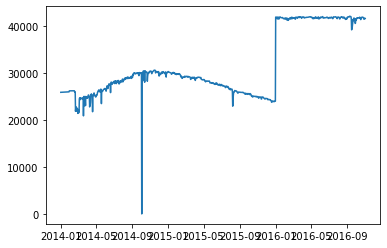

In [96]:
plt.plot(value_counts_df.index.to_pydatetime(), 
        value_counts_df.values)

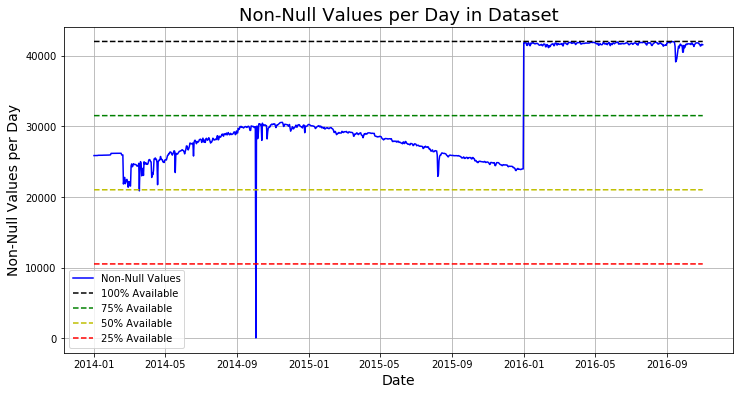

In [108]:
# Create plot of non-null values
plt.figure(figsize=(12, 6))
plt.plot(value_counts_df.index.to_pydatetime(), 
         value_counts_df.values, 'b-', label='Non-Null Values')
plt.plot(value_counts_df.index.to_pydatetime(), 
    max_threshold, 'k--', label='100% Available')
plt.plot(value_counts_df.index.to_pydatetime(), 
         0.75 * max_threshold, 'g--', label='75% Available')
plt.plot(value_counts_df.index.to_pydatetime(), 
         0.50 * max_threshold, 'y--', label='50% Available')
plt.plot(value_counts_df.index.to_pydatetime(), 
         0.25 * max_threshold, 'r--', label='25% Available')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Non-Null Values per Day', fontsize=14)
plt.title('Non-Null Values per Day in Dataset', fontsize=18)
plt.grid(); plt.legend()

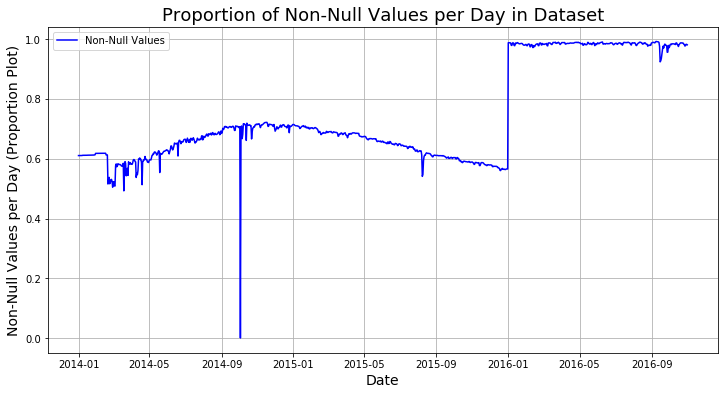

In [107]:
# Create plot of non-null values as proportion of all available values
plt.figure(figsize=(12, 6))
plt.plot(value_counts_df.index.to_pydatetime(), 
         value_counts_df.values / len(data[['CONS_NO']]), 
         'b-', label='Non-Null Values')
plt.ylabel('Non-Null Values per Day (Proportion Plot)', fontsize=14)
plt.title('Proportion of Non-Null Values per Day in Dataset', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.grid(); plt.legend()

### Interpretation
Now that the data has been sorted chronologically, we can see there is a trend in the number of missing values with time. 
- Number of non-missing values increases to 30k by late 2014, drops to 15 in 10/2014, and then rises back again.
- It then declines steadily to the beginning of 2016.
- From the beginning of 2016, the number of non-null values is virutally the same as the max number of consumers (~99%).
- For the majority of the dates, the number of non-null values is between 50 and 75%.

## Missing Values per Consumer
Now that we've visualized the trend in the number of missing values per day, we're going to look at the number of missing values per consumer. That is, how many missing values did each consumer report across the 1,034 days that data was recorded?

### TODOS
- Plot the number of non-null reading counts per consumer. 
- Implement the interpolation methods defined in the paper.
    - Average of previous and next day if not null.
    - Average of same day in previous and last week if not null.
- Visualize number of values that are outliers based on three sigma rule.